# Tutorial 08

## template fitting mock data test (B mode, non-parametric CMB)

The `simple likelihood` is designed for pipeline's sanity check:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cmbmodel
from afra.tools.ps_estimator import pstimator
import seaborn as sns
from dynesty import utils as dyfunc
from getdist import plots, MCSamples
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap30 = np.random.normal(0.,1.,size=vmap30.shape)*np.sqrt(vmap30)
nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=vmap353.shape)*np.sqrt(vmap353)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = hp.smoothing(mapcmb+map30f,fwhm=fwhm[0],verbose=0)+nmap30
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
map353 = hp.smoothing(mapcmb+map353f,fwhm=fwhm[3],verbose=0)+nmap353

fullmap = dict()
fullmap[95] = map95
fullmap[150] = map150

fullvar = dict()
fullvar[95] = vmap95
fullvar[150] = vmap150

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### 1st run with sync model

- mock data frequencies: 95, 150
- template frequency: 30
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw

fg truths:  {'beta_s': -3}
cmb truths:  {'bp_c_B_79.49999999999991': 0.004886427941413382, 'bp_c_B_139.4999999999998': 0.007970257922731865}
CPU times: user 36min 11s, sys: 2.35 s, total: 36min 14s
Wall time: 4min 49s


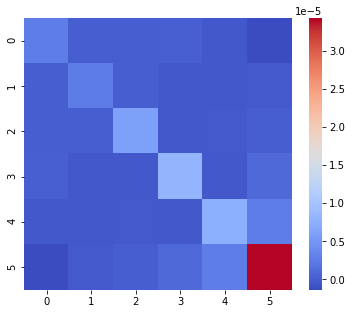

In [2]:
%%time

FREQS = [95.,150.]
TARGET = 'B'
NSAMP = 30
APOSCALE = 6.
PSBIN = 60
LMIN = 50
LMAX = 200

pipeline = af.tpfpipe(fullmap,mask=mask,variances=fullvar,fwhms=fullbeam,target=TARGET)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=NSAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f

s = syncmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=tmpmap,template_fwhms=None)
s.reset({'beta_s':-3})

b = cmbmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,target=TARGET)
auto_cmb_b = est.autoBP(mapcmb)
for i in range(len(auto_cmb_b[0])):
    name = 'bp_c_B_'+str(auto_cmb_b[0][i])
    b.reset({name: auto_cmb_b[1][i]})
    
print ('fg truths: ',s.params)
print ('cmb truths: ',b.params)

mock_bp = s.bandpower()+b.bandpower()

iter: 30277 | +1000 | bound: 42 | nc: 1 | ncall: 98446 | eff(%): 31.771 | loglstar:   -inf < -0.002 <    inf | logz: -30.034 +/-  0.241 | dlogz:  0.001 >  1.009                                      

Removed no burn in


iter: 31059 | +1000 | bound: 67 | nc: 1 | ncall: 137158 | eff(%): 23.374 | loglstar:   -inf < -0.001 <    inf | logz: -30.820 +/-  0.244 | dlogz:  0.001 >  1.009                                     

Removed no burn in


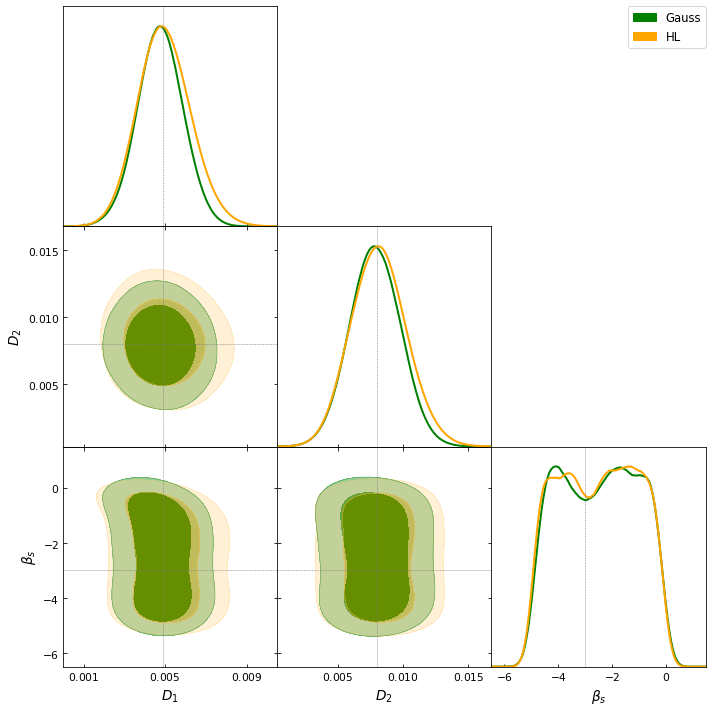

In [3]:
names = [r'$D_1$',r'$D_2$',r'$\beta_s$']
truths = list(auto_cmb_b[1]) + [-3]
KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = s
pipeline.param_range = {'bp_c_B_121.5':[0.,0.1],'bp_c_B_201.5':[0.,0.1]}
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
pipeline.likelihood='gauss'
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

pipeline.likelihood='hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### 2nd run with dust model

- mock data frequencies: 95, 150
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

fg truths:  {'beta_d': 1.5}
cmb truths:  {'bp_c_B_79.49999999999991': 0.004886427941413382, 'bp_c_B_139.4999999999998': 0.007970257922731865}
CPU times: user 16min 30s, sys: 250 ms, total: 16min 30s
Wall time: 2min 4s


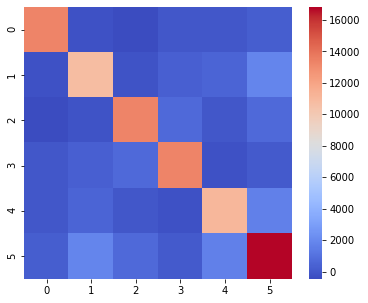

In [4]:
%%time

FREQS = [95.,150.]
TARGET = 'B'
NSAMP = 30
APOSCALE = 6.
PSBIN = 60
LMIN = 50
LMAX = 200

pipeline = af.tpfpipe(fullmap,mask=mask,variances=fullvar,fwhms=fullbeam)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=NSAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[353] = map353f

d = dustmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=tmpmap,template_fwhms=None)
d.reset({'beta_d':1.5})

b = cmbmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,target=TARGET)
auto_cmb_b = est.autoBP(mapcmb)
for i in range(len(auto_cmb_b[0])):
    name = 'bp_c_B_'+str(auto_cmb_b[0][i])
    b.reset({name: auto_cmb_b[1][i]})
    
print ('fg truths: ',d.params)
print ('cmb truths: ',b.params)

mock_bp = d.bandpower()+b.bandpower()

iter: 9848 | +1000 | bound: 10 | nc: 1 | ncall: 50113 | eff(%): 21.647 | loglstar:   -inf < -0.000 <    inf | logz: -9.610 +/-  0.131 | dlogz:  0.001 >  1.009                                        

Removed no burn in


iter: 34733 | +1000 | bound: 50 | nc: 1 | ncall: 110050 | eff(%): 32.470 | loglstar:   -inf < -0.018 <    inf | logz: -34.631 +/-  0.265 | dlogz:  0.001 >  1.009                                     

Removed no burn in


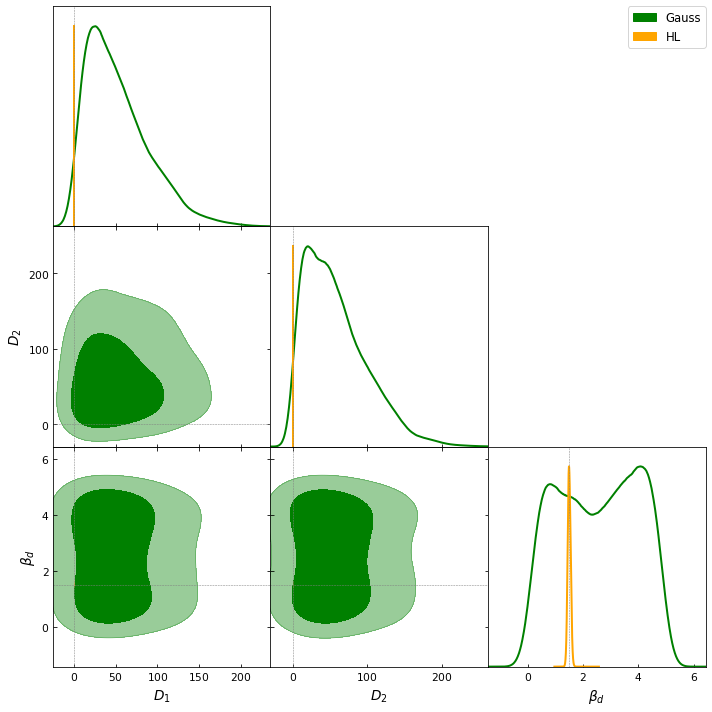

In [5]:
names = [r'$D_1$',r'$D_2$',r'$\beta_d$']
truths = list(auto_cmb_b[1]) + [1.5]
KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = d
pipeline.param_range = {'bp_c_B_121.5':[0.,0.1],'bp_c_B_201.5':[0.,0.1]}
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
pipeline.likelihood='gauss'
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

pipeline.likelihood='hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

#### 3rd run with sync+dust model

- mock data frequencies: 95, 150
- template frequency: 30, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

fg truths:  {'beta_s': -3.3, 'beta_d': 1.5, 'rho': 0.1}
cmb truths:  {'bp_c_B_79.49999999999991': 0.004886427941413382, 'bp_c_B_139.4999999999998': 0.007970257922731865}
CPU times: user 48min 19s, sys: 1.51 s, total: 48min 20s
Wall time: 6min 11s


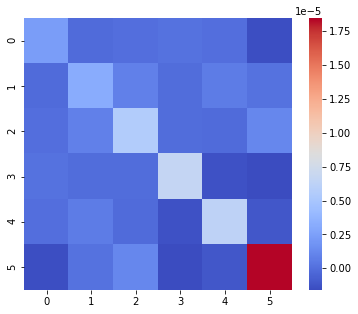

In [6]:
%%time

FREQS = [95.,150.]
TARGET = 'B'
NSAMP = 40
APOSCALE = 6.
PSBIN = 60
LMIN = 50
LMAX = 200

pipeline = af.tpfpipe(fullmap,mask=mask,variances=fullvar,fwhms=fullbeam,target=TARGET)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=NSAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f
tmpmap[353] = map353f

c = syncdustmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
                  templates=tmpmap,template_fwhms=None)
c.reset({'beta_s':-3.3})
c.reset({'beta_d':1.5})
c.reset({'rho':0.1})

b = cmbmodel(freqlist=FREQS,target=TARGET,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,target=TARGET)
auto_cmb_b = est.autoBP(mapcmb)
for i in range(len(auto_cmb_b[0])):
    name = 'bp_c_B_'+str(auto_cmb_b[0][i])
    b.reset({name: auto_cmb_b[1][i]})
    
print ('fg truths: ',c.params)
print ('cmb truths: ',b.params)

mock_bp = c.bandpower()+b.bandpower()

iter: 33942 | +1000 | bound: 56 | nc: 1 | ncall: 119040 | eff(%): 29.353 | loglstar:   -inf < -0.012 <    inf | logz: -33.849 +/-  0.263 | dlogz:  0.001 >  1.009                                     

Removed no burn in


iter: 34232 | +1000 | bound: 51 | nc: 1 | ncall: 112349 | eff(%): 31.359 | loglstar:   -inf < -0.007 <    inf | logz: -34.148 +/-  0.264 | dlogz:  0.001 >  1.009                                     

Removed no burn in


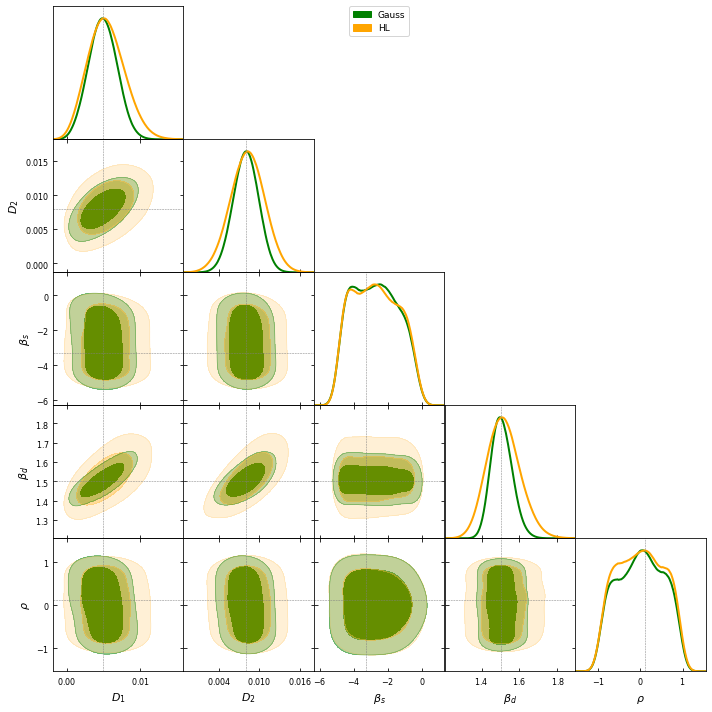

In [7]:
names = [r'$D_1$',r'$D_2$',r'$\beta_s$',r'$\beta_d$',r'$\rho$']
truths = list(auto_cmb_b[1]) + [-3.3,1.5,0.1]
KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = c
pipeline.param_range = {'bp_c_B_121.5':[0.,0.1],'bp_c_B_201.5':[0.,0.1]}
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
pipeline.likelihood='gauss'
samples1 = MCSamples(samples=samples,weights=weights,names=names,label='Gauss')

pipeline.likelihood='hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
samples2 = MCSamples(samples=samples,weights=weights,names=names,label='HL')

g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add=0.4
g.triangle_plot([samples1,samples2],markers=truths,
                line_args=[{'lw':'2', 'color':'green'},{'lw':2, 'color':'orange'}],
                contour_colors=['green','orange'],
                filled=True, contour_lws=2)

end